In [1]:
from data_loading.animal_keypoints_dataset import AnimalKeypointsDataset
from utils.transforms import RandomRotation, RandomFlip, RandomRatioCrop
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from models.conv_pose_machines import ConvolutionalPoseMachines
from utils.losses import MSECELoss, HMapsMSELoss
from utils.set_random_seed import set_random_seed, SEED
import torch
import os
# %cd ../../
from pose_estimation.cats.train import train
from utils.model_saver import ModelSaver
# %cd ./pose_estimation/cats/

set_random_seed(SEED)

INIT_WEIGHT_PATH = '../../models/weights/ConvolutionalPoseMachines_6_stages/HMapsMSELoss/Adam_lr_1e-05_betas_(0o9_0o999)_eps_1e-08/ConvolutionalPoseMachines_E1329_B6.pth'
ALPHA = 0.00001
IMAGE_SIZE = (368, 368)
EPOCHS = 1350
TRAIN_BATCH_SIZE = 6
TEST_BATCH_SIZE = 4
LOG_STEP = 30
SAVE_MODEL_STEP = 70
START_EPOCH = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

all_tform = transforms.Compose([
    RandomFlip(0.5, 0.5),
    RandomRatioCrop(0.1, 0.1, 0.9, 0.9),
    RandomRotation((-30, 30)),
])

img_tform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
])

data_train = AnimalKeypointsDataset(
    json_file_path='../../dataset/cats/train/keypoints_annotations.json',
    image_dir='../../dataset/cats/train/labeled/',
    transform={'all': all_tform,
               'image': img_tform,
               'keypoints': transforms.ToTensor()},
    heatmap=True)
data_train_loader = DataLoader(data_train, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=0)

data_test = AnimalKeypointsDataset(
    json_file_path='../../dataset/cats/test/keypoints_annotations.json',
    image_dir='../../dataset/cats/test/labeled/',
    transform={'all': all_tform,
               'image': img_tform,
               'keypoints': transforms.ToTensor()},
    heatmap=True)
data_test_loader = DataLoader(data_test, batch_size=TEST_BATCH_SIZE, shuffle=True, num_workers=0)

Global seed set to 27


/home/tehnik/coding/pycharm/pytorch_course_animal_pose_estimation


Global seed set to 27


/home/tehnik/coding/pycharm/pytorch_course_animal_pose_estimation/pose_estimation/cats
Weights not found.
Model's weights will be saved to: ../../models/weights/ConvolutionalPoseMachines/HMapsMSELoss/Adam_lr_1e-05_betas_(0o9_0o999)_eps_1e-08/
Train loss: 1038.0255790378737, Epoch: 0
Test loss: 779.8465474446615, Epoch: 0


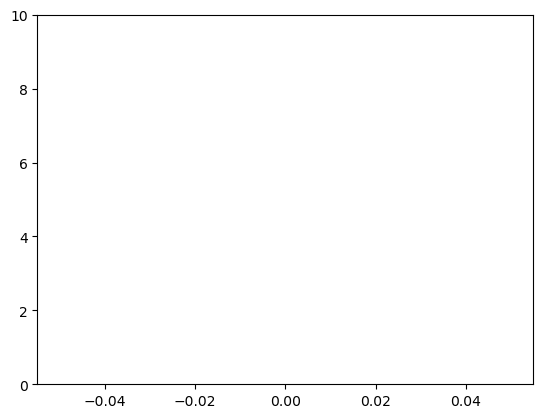

Train loss: 5.76196000887, Epoch: 30
Test loss: 6.731025218963623, Epoch: 30


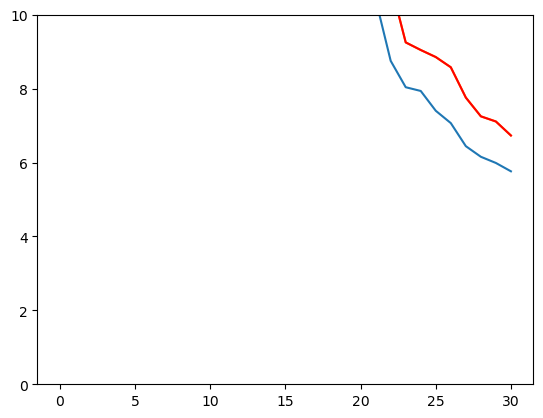

Train loss: 3.8000676528267237, Epoch: 60
Test loss: 4.387636820475261, Epoch: 60


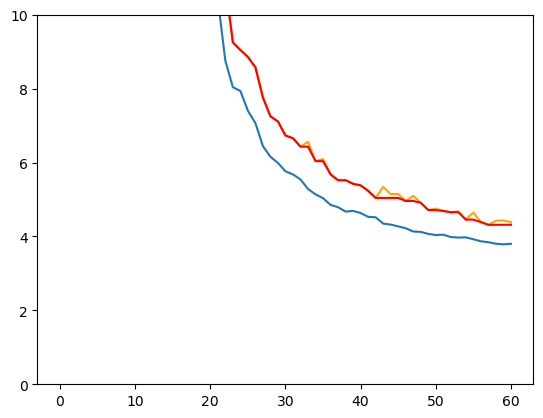

Train loss: 3.45384346920511, Epoch: 90
Test loss: 3.7239964405695596, Epoch: 90


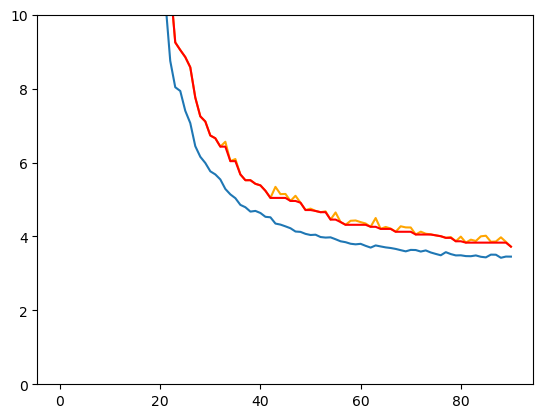

Train loss: 3.287713330724965, Epoch: 120
Test loss: 3.6440916061401367, Epoch: 120


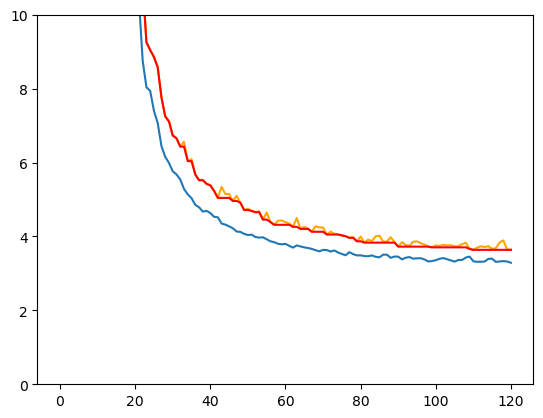

Train loss: 3.3117956804192583, Epoch: 150
Test loss: 3.565828323364258, Epoch: 150


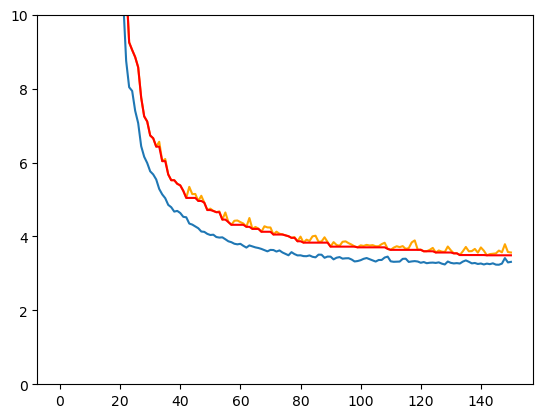

Train loss: 3.252909743267557, Epoch: 180
Test loss: 3.4298518896102905, Epoch: 180


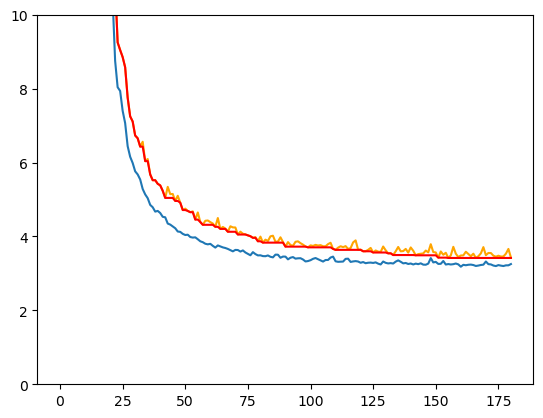

Train loss: 3.212930606759113, Epoch: 210
Test loss: 3.471589207649231, Epoch: 210


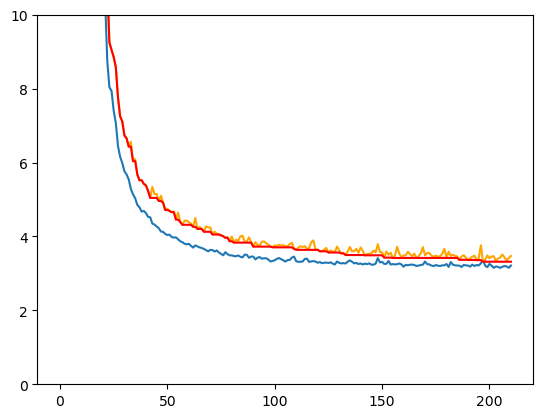

Train loss: 3.1680242289667544, Epoch: 240
Test loss: 3.3662668466567993, Epoch: 240


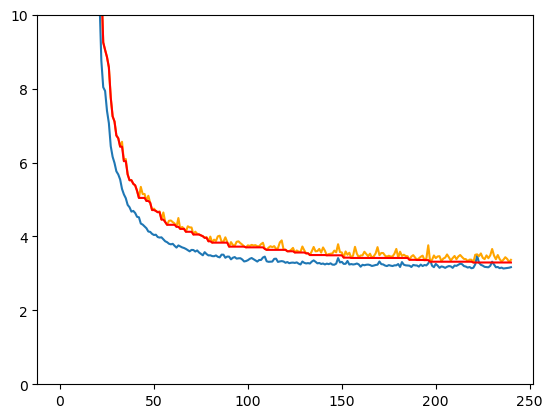

Train loss: 3.150716429171355, Epoch: 270
Test loss: 3.34565269947052, Epoch: 270


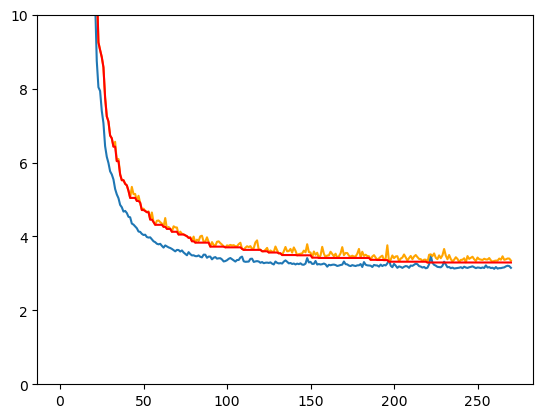

Train loss: 3.1351769074149756, Epoch: 300
Test loss: 3.275785048802694, Epoch: 300


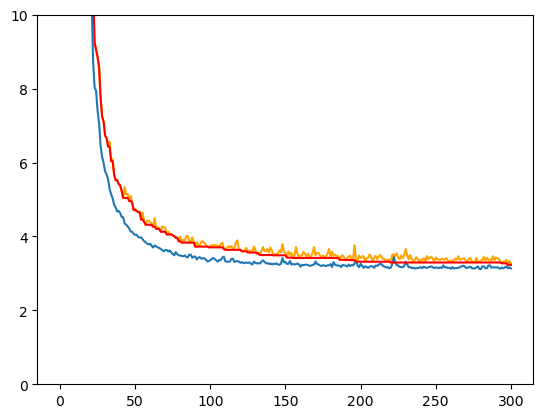

Train loss: 3.106503103090369, Epoch: 330
Test loss: 3.296846946080526, Epoch: 330


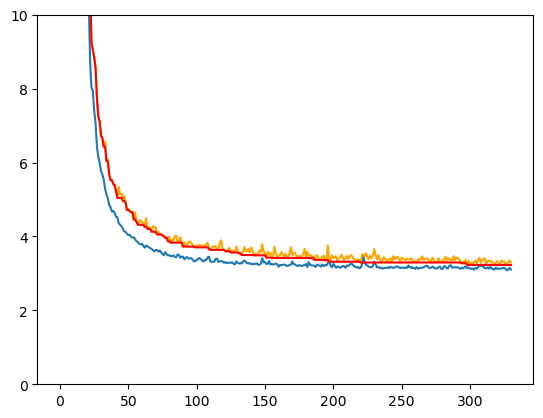

Train loss: 3.120500958484152, Epoch: 360
Test loss: 3.259357730547587, Epoch: 360


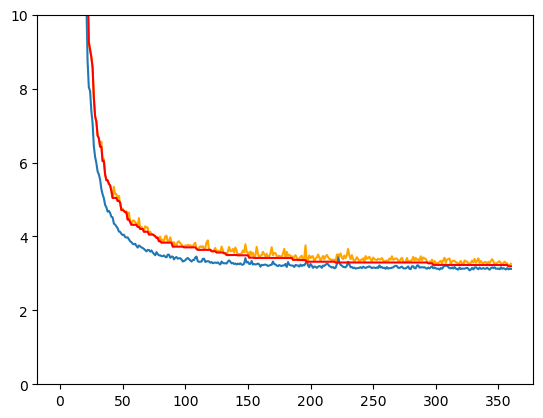

Train loss: 3.152281906293786, Epoch: 390
Test loss: 3.342951854070028, Epoch: 390


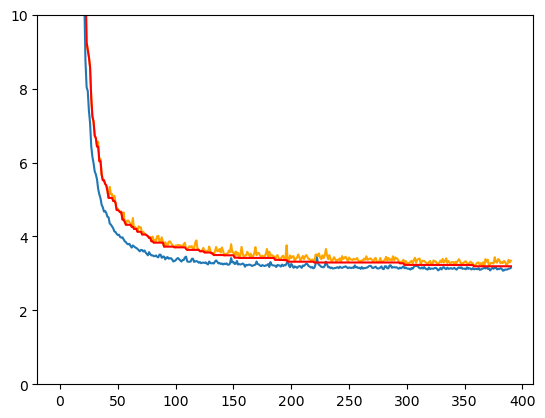

Train loss: 3.109075867611429, Epoch: 420
Test loss: 3.1735770304997764, Epoch: 420


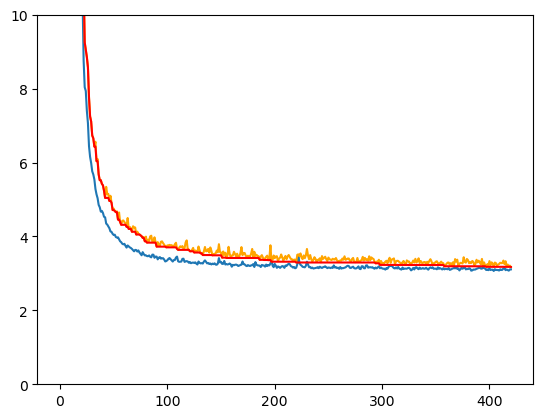

Train loss: 3.0769331558890967, Epoch: 450
Test loss: 3.2418785095214844, Epoch: 450


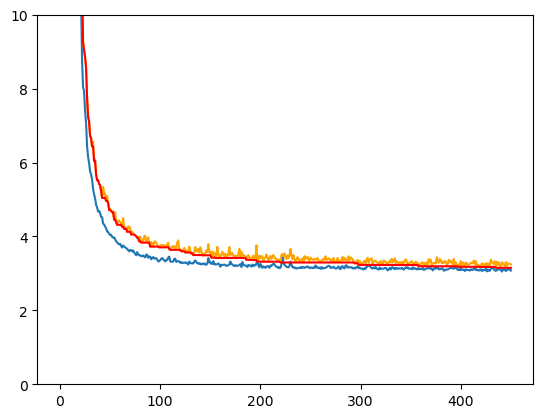

Train loss: 3.067475920138152, Epoch: 480
Test loss: 3.25357449054718, Epoch: 480


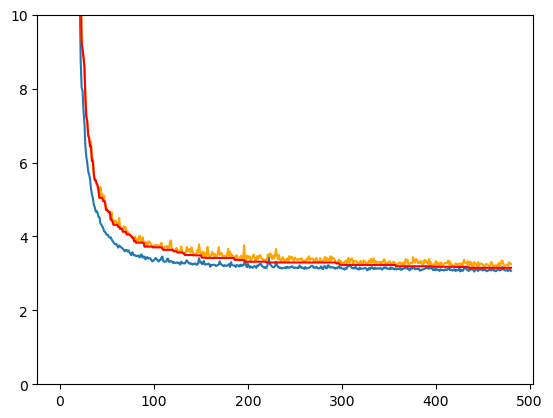

Train loss: 3.0699395304140835, Epoch: 510
Test loss: 3.2007729609807334, Epoch: 510


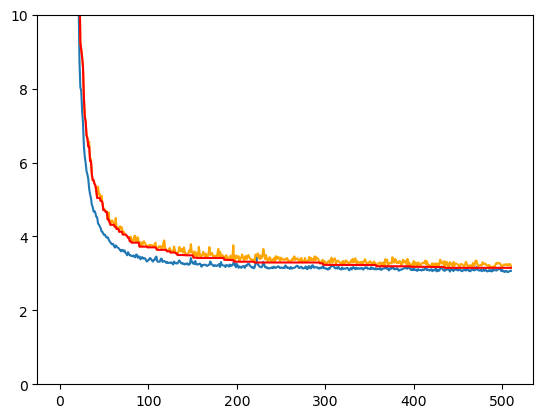

Train loss: 3.063462278117304, Epoch: 540
Test loss: 3.2677639722824097, Epoch: 540


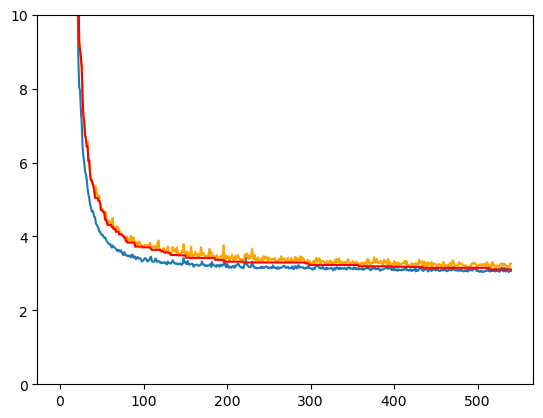

Train loss: 3.0470228609831436, Epoch: 570
Test loss: 3.251656254132589, Epoch: 570


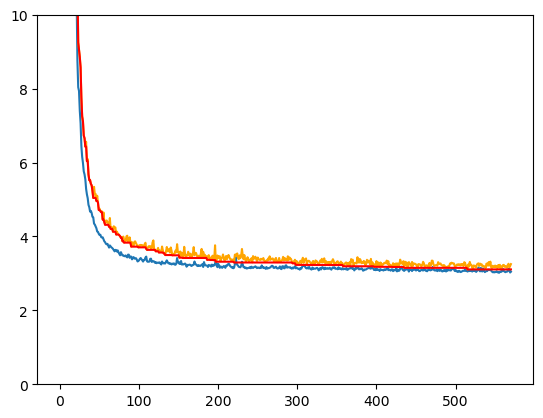

Train loss: 3.1227178988249404, Epoch: 600
Test loss: 3.2625630299250283, Epoch: 600


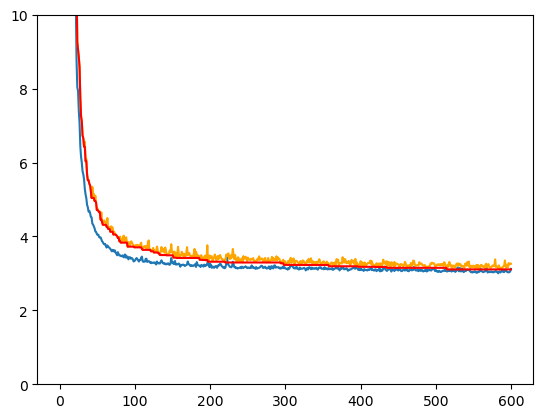

Train loss: 3.0298037321671196, Epoch: 630
Test loss: 3.2495193084081015, Epoch: 630


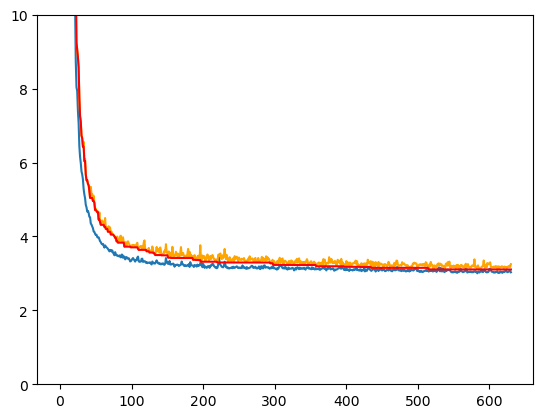

Train loss: 2.9843007170635723, Epoch: 660
Test loss: 3.1759587128957114, Epoch: 660


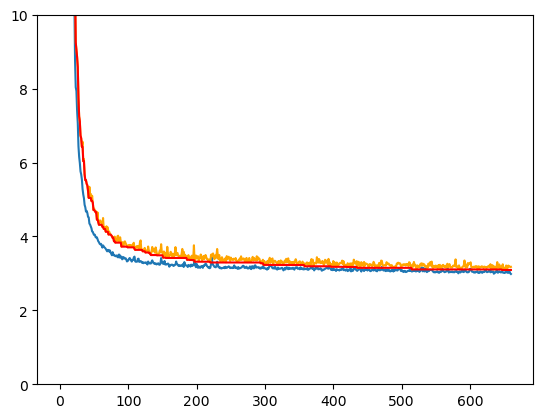

Train loss: 3.026127576828003, Epoch: 690
Test loss: 3.167109807332357, Epoch: 690


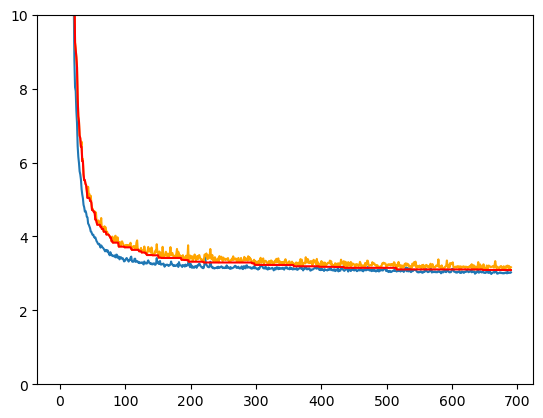

Train loss: 3.013796516086744, Epoch: 720
Test loss: 3.116057594617208, Epoch: 720


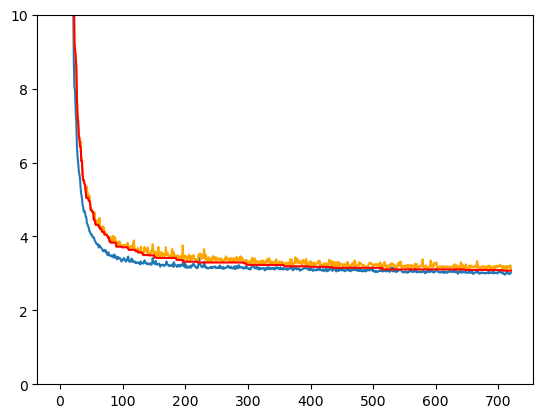

Train loss: 2.9793684689894966, Epoch: 750
Test loss: 3.161003589630127, Epoch: 750


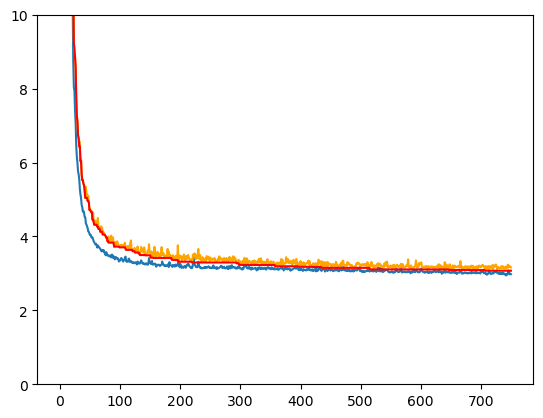

Train loss: 2.9578851927881655, Epoch: 780
Test loss: 3.140437046686808, Epoch: 780


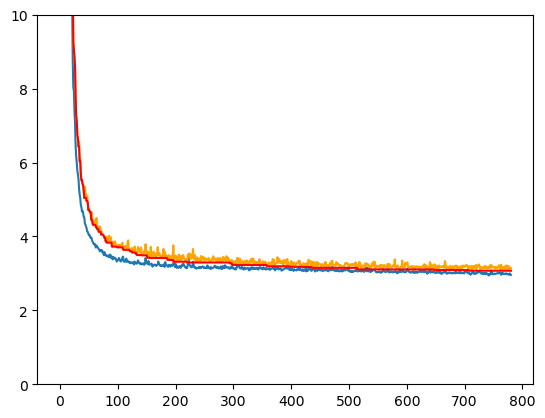

Train loss: 2.9383414517278257, Epoch: 810
Test loss: 3.1176756223042807, Epoch: 810


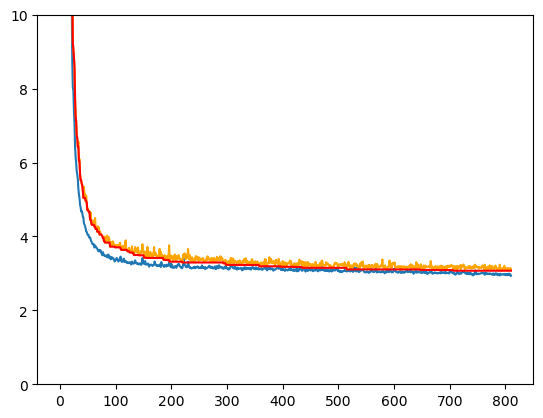

Train loss: 3.0027131308679995, Epoch: 840
Test loss: 3.3397236665089927, Epoch: 840


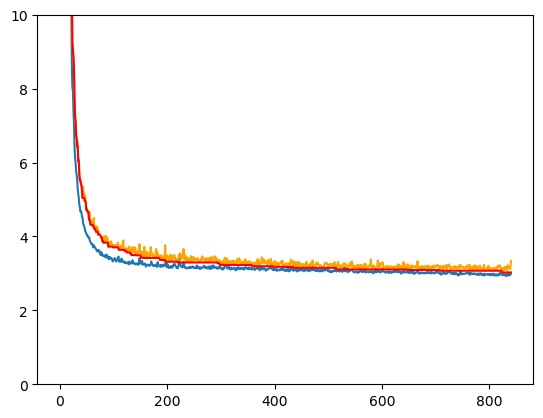

Train loss: 2.973056357839833, Epoch: 870
Test loss: 3.0932830969492593, Epoch: 870


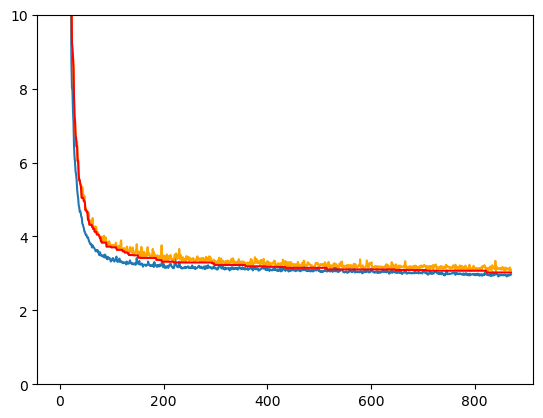

Train loss: 2.9519784761511763, Epoch: 900
Test loss: 3.1553550561269126, Epoch: 900


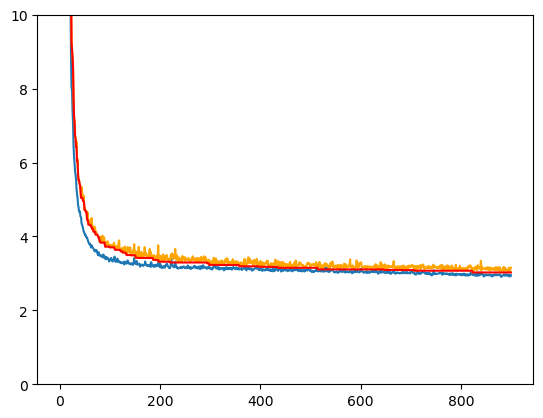

Train loss: 2.946651541668436, Epoch: 930
Test loss: 3.1040612061818442, Epoch: 930


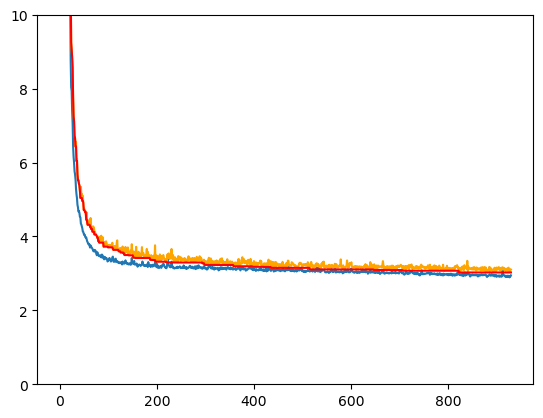

Train loss: 2.908138710519542, Epoch: 960
Test loss: 3.0826006333033242, Epoch: 960


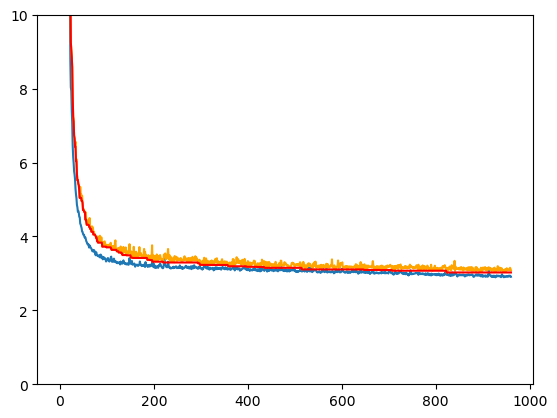

Train loss: 2.884041112402211, Epoch: 990
Test loss: 3.070043762524923, Epoch: 990


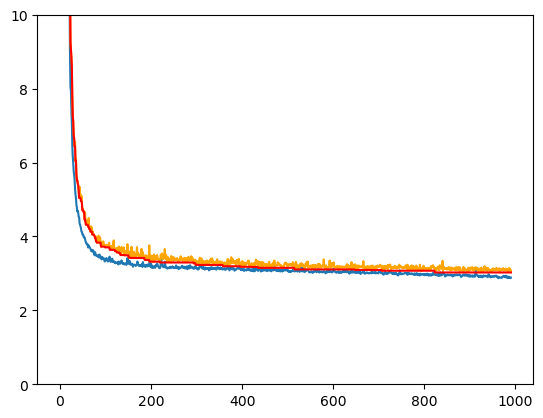

Train loss: 2.871064434880796, Epoch: 1020
Test loss: 3.1127911806106567, Epoch: 1020


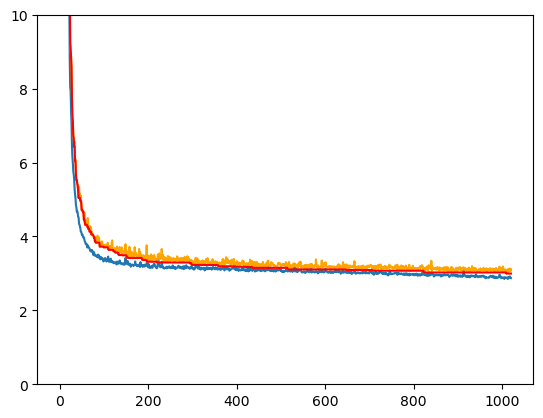

Train loss: 2.8433300515879756, Epoch: 1050
Test loss: 3.0786423683166504, Epoch: 1050


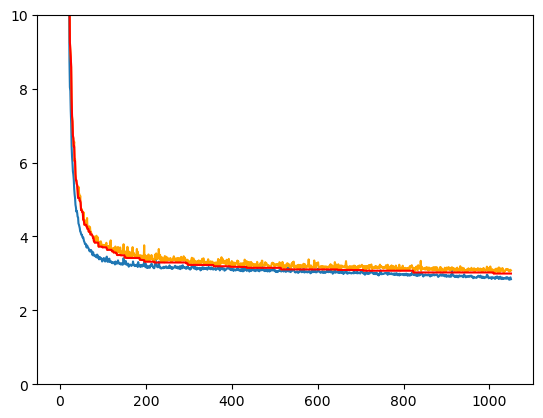

Train loss: 2.818052644314973, Epoch: 1080
Test loss: 2.991627295811971, Epoch: 1080


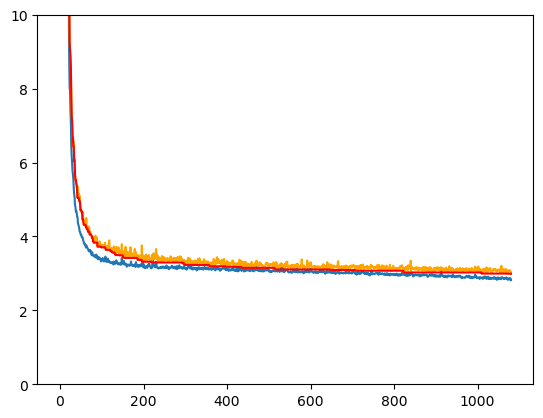

Train loss: 2.821840338085009, Epoch: 1110
Test loss: 3.0785423119862876, Epoch: 1110


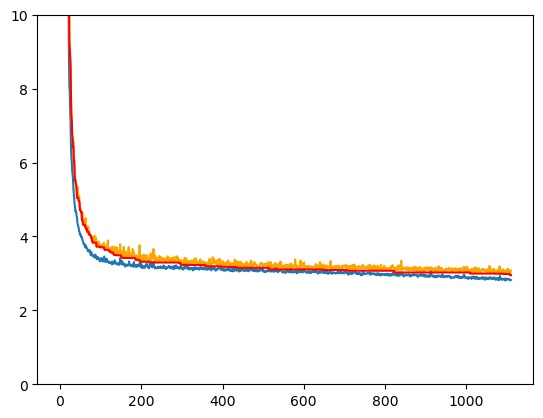

Train loss: 2.81276013540185, Epoch: 1140
Test loss: 3.0361429850260415, Epoch: 1140


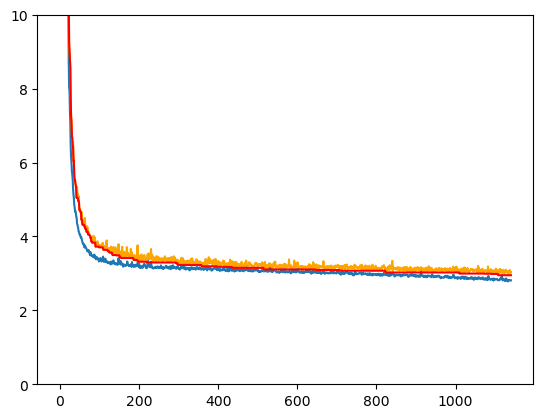

Train loss: 2.8040765472080396, Epoch: 1170
Test loss: 3.0845786333084106, Epoch: 1170


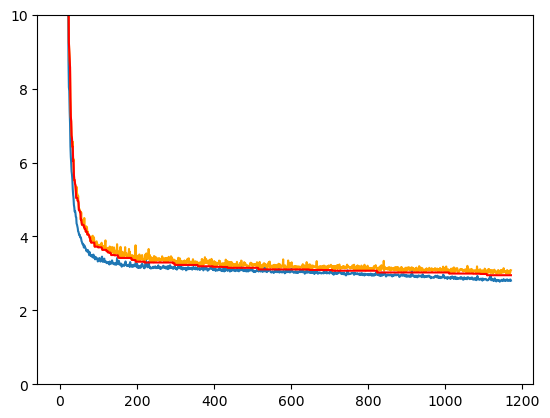

Train loss: 2.79852993591972, Epoch: 1200
Test loss: 3.068166414896647, Epoch: 1200


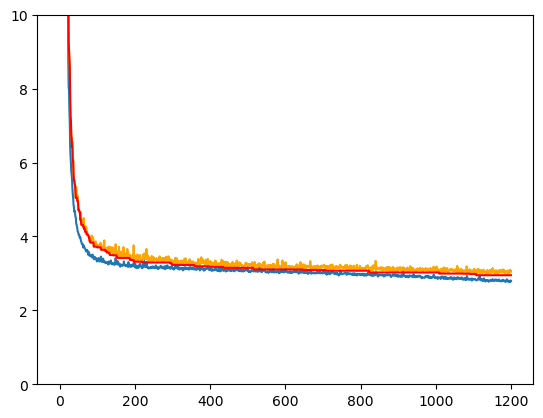

Train loss: 2.761136749516363, Epoch: 1230
Test loss: 3.0418574015299478, Epoch: 1230


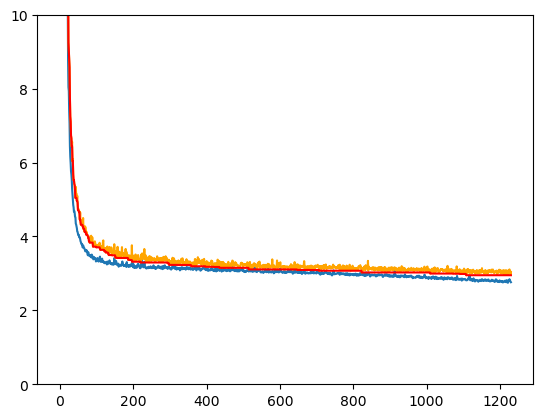

Train loss: 2.7675021834995435, Epoch: 1260
Test loss: 2.9854607582092285, Epoch: 1260


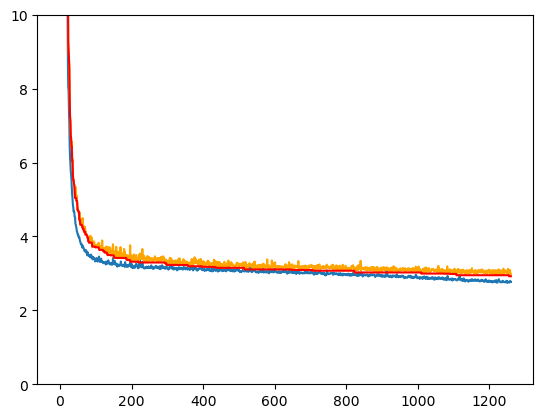

Train loss: 2.774904727935791, Epoch: 1290
Test loss: 3.0242591301600137, Epoch: 1290


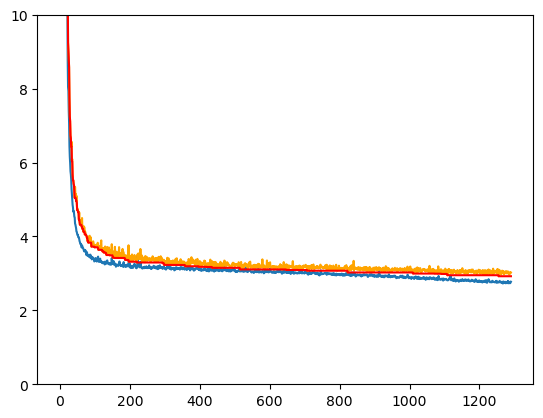

Train loss: 2.716266103412794, Epoch: 1320
Test loss: 3.104097366333008, Epoch: 1320


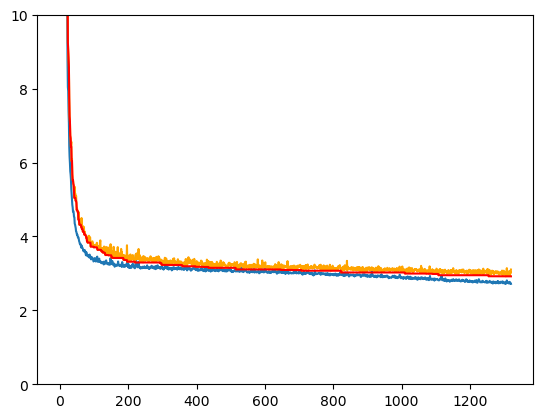

In [1]:
model = ConvolutionalPoseMachines(
        n_keypoints=16,
        n_substages=3,
        n_base_ch=64,
        img_feat_ch=16,
        device=device
    )
if os.path.isfile(INIT_WEIGHT_PATH):
    model.load_state_dict(torch.load(INIT_WEIGHT_PATH))
else:
    print("Weights not found.")
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
loss = HMapsMSELoss().to(device)

model_saver = ModelSaver(model,
                         TRAIN_BATCH_SIZE,
                         save_freq=SAVE_MODEL_STEP,
                         start_epoch=START_EPOCH,
                         loss=loss,
                         optimizer=optimizer)

train(
    model=model,
    data_train=data_train_loader,
    data_test=data_test_loader,
    loss=loss,
    optimizer=optimizer,
    epochs=EPOCHS,
    model_saver=model_saver,
    logging_step=LOG_STEP,
    device=device
)